## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC_old import *

### Load data and preprocess

In [713]:
%time s1 = sc.read_h5ad('../data/3777-SM-2-CTTGTA_S2.h5ad') # read in one of the annotated example files

CPU times: user 3.86 s, sys: 334 ms, total: 4.19 s
Wall time: 4.2 s


In [714]:
s1 # see contents of AnnData object

AnnData object with n_obs × n_vars = 5754 × 38459 
    obs: 'ken_filter'

Standard preprocessing to get metadata for barcodes:

In [715]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# save raw counts in layer
s1.layers['raw_counts'] = s1.X.copy()

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 1.67 s, sys: 1.02 s, total: 2.69 s
Wall time: 2.7 s


In [716]:
%%time
# normalize, scale, and perform PCA
sc.pp.normalize_total(s1, target_sum=10000)
sc.pp.log1p(s1)

# save log1p-transformed counts in layer
s1.layers['log1p_counts'] = s1.X.copy()

# scale and perform PCA
sc.pp.scale(s1, max_value=10)
sc.tl.pca(s1, n_comps=500)

CPU times: user 5min 57s, sys: 2min 27s, total: 8min 24s
Wall time: 13 s


In [717]:
%%time 
# generate neighborhood graph, cluster with louvain, and perform PAGA analysis
sc.pp.neighbors(s1, n_neighbors=90, random_state=18, n_pcs=500)
sc.tl.louvain(s1, random_state=18)
sc.tl.paga(s1)

CPU times: user 13.7 s, sys: 21 s, total: 34.7 s
Wall time: 4.34 s


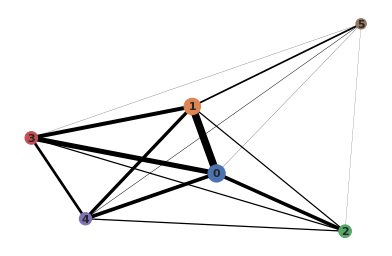

In [718]:
# show PAGA diagram of cluster similarity
sc.pl.paga(s1, frameon=False)

In [719]:
# perform UMAP using PAGA to initialize
%time sc.tl.umap(s1, init_pos=sc.tl._utils.get_init_pos_from_paga(s1), random_state=18)

CPU times: user 19.7 s, sys: 188 ms, total: 19.9 s
Wall time: 19.7 s


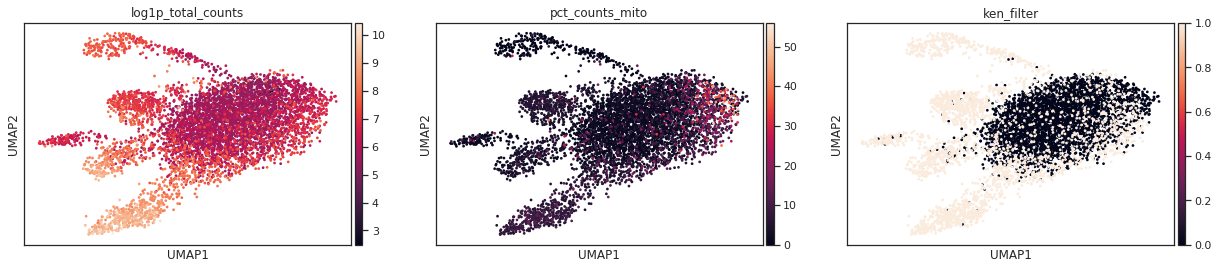

In [720]:
# show barcodes with low counts, high mito, and Ken's filter
sc.pl.umap(s1, color=['log1p_total_counts', 'pct_counts_mito', 'ken_filter'], size=30)

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [721]:
from skimage.filters import threshold_li, threshold_otsu, threshold_mean, threshold_triangle # popular thresholding methods

In [722]:
# use a few methods on the log-transformed total counts for each barcode:
thresh_otsu = threshold_otsu(np.array(s1.obs['log1p_total_counts']))
thresh_li = threshold_li(np.array(s1.obs['log1p_total_counts']))
thresh_mean = threshold_mean(np.array(s1.obs['log1p_total_counts']))
thresh_triangle = threshold_triangle(np.array(s1.obs['log1p_total_counts']))

Real max thresholding

Plot thresholds on `log1p_total_counts`:

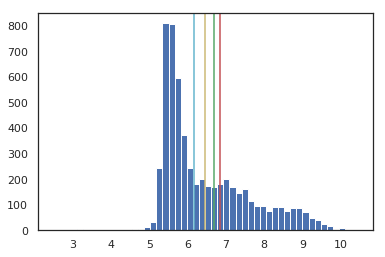

In [723]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(thresh_otsu, color='r') # otsu threshold
plt.axvline(thresh_li, color='g') # li threshold
plt.axvline(thresh_mean, color='y') # mean threshold
plt.axvline(thresh_triangle, color='c') # triangle threshold
#plt.axvline(real_max[0], color='k') # real max threshold

In [724]:
# get subset of array from 0 to where the threshold ends
y_array = _[0]
x_array = _[1]
x_array_end = np.where(x_array <= thresh_li)
sub_y_array = y_array[slice(0, np.amax(x_array_end))]
sub_x_array = x_array[slice(0, np.amax(x_array_end))]

In [725]:
# find the peak of a distribution within the range of 0 and the threshold
max_value = max(sub_y_array)
max_index = np.where(sub_y_array == max_value)
real_max = sub_x_array[max_index]

### Find inflection point

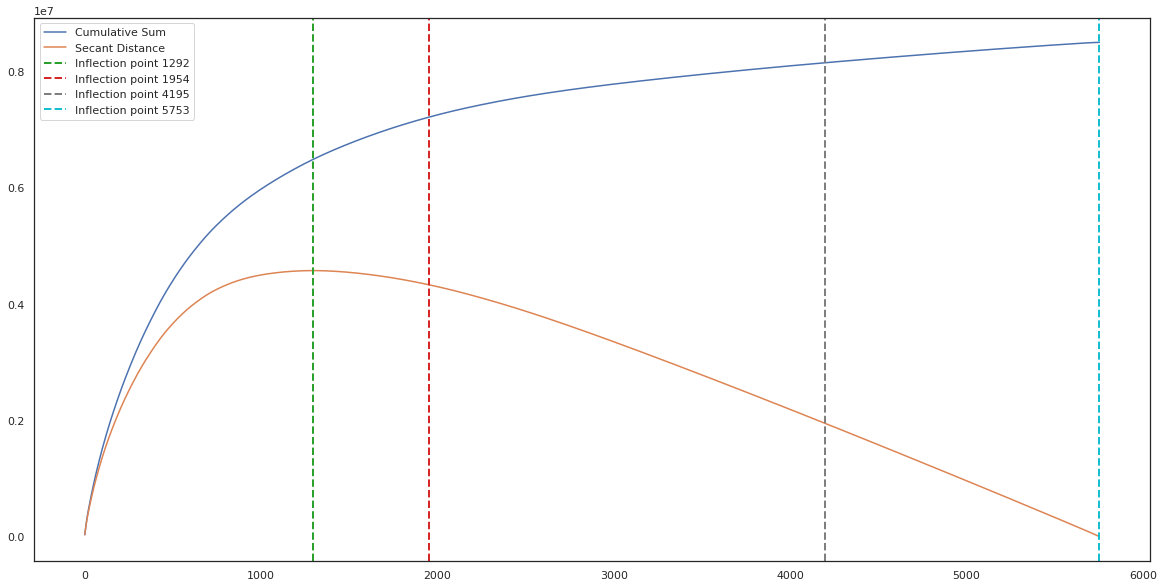

Inflection point at index
3839    1292
4016    1954
1817    4195
0       5753
Name: total_counts, dtype: int64 for [0, 20, 70, 100] percentiles of greatest secant distances


{0: 1292, 20: 1954, 70: 4195, 100: 5753}

In [726]:
# inflection_percentiles are percentages of maximum secant distance. we wanna pick one to the right of the maximum
find_inflection(s1, inflection_percentiles = [0,20,70,100], output_prefix='')

The purple cutoff looks pretty good if we were manually filtering the data. Let's see how many total counts and log1p-transformed total counts the cell at that position has:

In [727]:
s1.obs['log1p_total_counts'][3401] # see the log-transformed total counts for the cutoff point; this should be close to otsu or li threshold

5.768321

So the above number should correspond to a cutoff between the two 'lumps' in our `log1p_total_counts` distribution, and it looks close to our `Otsu`, `mean`, and `Li` thresholds.  
Let's plot it to compare to the automated thresholds from `skimage`:

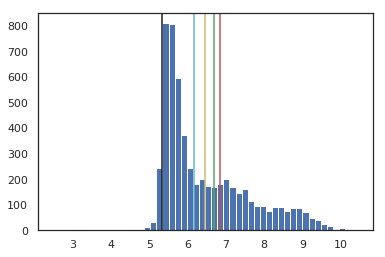

In [728]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(thresh_otsu, color='r') # otsu
plt.axvline(thresh_li, color='g') # li
plt.axvline(thresh_mean, color='y') # mean threshold
plt.axvline(thresh_triangle, color='c') # triangle threshold
plt.axvline(real_max[0], color='k') # real max threshold
#plt.axvline(s1.obs['log1p_total_counts'][3401], color='k') # threshold chosen from one of the inflection point percentage cutoffs

Li and Mean thresholding line up pretty well with what we would choose beyond inflection point.

---
Now, we want to generate a training set from the barcodes __below__ our `log1p_total_counts` threshold.  
To do so, we will randomly sample a reasonable number of barcodes (>1000), with probabilities __decreasing__ with __increasing total counts__.

In [729]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['train_prob_li'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['log1p_total_counts']<thresh_li, 'train_prob_li'] = np.reciprocal(s1.obs.loc[s1.obs['log1p_total_counts']<thresh_li, 'total_counts']+1)
s1.obs['train_prob_li'] /= s1.obs['train_prob_li'].sum()

In [730]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['train_prob_mean'] = 0

# of all the barcodes BELOW our threshold (using Mean here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['log1p_total_counts']<thresh_mean, 'train_prob_mean'] = np.reciprocal(s1.obs.loc[s1.obs['log1p_total_counts']<thresh_mean, 'total_counts']+1)
s1.obs['train_prob_mean'] /= s1.obs['train_prob_mean'].sum()

In [731]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['train_prob_real_max'] = 0

# of all the barcodes BELOW our threshold (using Mean here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['log1p_total_counts']<real_max[0], 'train_prob_real_max'] = np.reciprocal(s1.obs.loc[s1.obs['log1p_total_counts']<real_max[0], 'total_counts']+1)
s1.obs['train_prob_real_max'] /= s1.obs['train_prob_real_max'].sum()

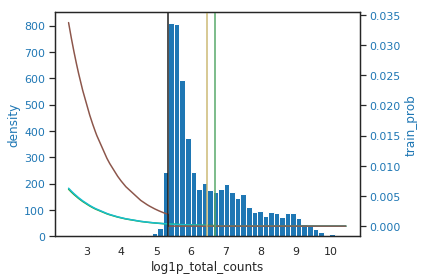

In [732]:
# plot the probability of drawing a barcode for our training set versus the log1p_total_counts
# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('log1p_total_counts')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['log1p_total_counts'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# threshold li probability
color_li = 'tab:green'
ax2.set_ylabel('train_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['log1p_total_counts'], s1.obs['train_prob_li'], color=color_li)
ax2.tick_params(axis='y', labelcolor=color)

# threshold mean probability
color_mean = 'tab:cyan'
ax2.plot(s1.obs['log1p_total_counts'], s1.obs['train_prob_mean'], color=color_mean)
ax2.tick_params(axis='y', labelcolor=color)

# real max probability
color_real_max = 'tab:brown'
ax2.plot(s1.obs['log1p_total_counts'], s1.obs['train_prob_real_max'], color=color_real_max)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_li, color='g') # li threshold
plt.axvline(thresh_mean, color = 'y') # mean threshold
plt.axvline(real_max[0], color = 'k') # real max threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [733]:
# add emptyDrops results
emptyDropsThresh = pd.read_csv("emptyDrops-thresh-3777-S2.csv")

In [734]:
# only use when barcode data type does not match with index data type
emptyDropsThresh.barcode = emptyDropsThresh.barcode.astype(str)

In [735]:
s1.obs = s1.obs.merge(emptyDropsThresh, left_on = 'index', right_on = 'barcode')

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 


In [736]:
s1.obs

,ken_filter,mean_mito,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,train_prob_li,train_prob_mean,train_prob_real_max,Total,LogProb,PValue,Limited,FDR,empty,barcode
0,1,66.027023,7182,8.879472,33924.0,10.431908,20.988091,28.599222,37.619385,51.173211,...,0.000000,0.000000,0.000000,33924,-28708.137585,0.0001,True,0.0,0,0
1,1,86.945946,6016,8.702344,26851.0,10.198095,28.881606,35.588991,43.417377,55.886187,...,0.000000,0.000000,0.000000,26851,-23459.064440,0.0001,True,0.0,0,1
2,1,43.270271,6099,8.716044,25590.0,10.149996,19.921844,27.018367,36.291520,50.691676,...,0.000000,0.000000,0.000000,25590,-23374.140686,0.0001,True,0.0,0,2
3,1,45.027027,5938,8.689296,24390.0,10.101970,21.775318,28.798688,37.872079,51.779418,...,0.000000,0.000000,0.000000,24390,-22470.990472,0.0001,True,0.0,0,8
4,1,35.324326,5646,8.638880,24030.0,10.087100,21.223471,28.942988,38.193924,53.116937,...,0.000000,0.000000,0.000000,24030,-21524.208000,0.0001,True,0.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5749,0,0.027027,15,2.772589,15.0,2.772589,100.000000,100.000000,100.000000,100.000000,...,0.004583,0.004706,0.025274,15,NaN,NaN,NaN,NaN,1,4579
5750,0,0.027027,11,2.484907,14.0,2.708050,100.000000,100.000000,100.000000,100.000000,...,0.004889,0.005020,0.026958,14,NaN,NaN,NaN,NaN,1,5720
5751,0,0.000000,12,2.564949,13.0,2.639057,100.000000,100.000000,100.000000,100.000000,...,0.005238,0.005378,0.028884,13,NaN,NaN,NaN,NaN,1,5003
5752,0,0.000000,12,2.564949,12.0,2.564949,100.000000,100.000000,100.000000,100.000000,...,0.005641,0.005792,0.031106,12,NaN,NaN,NaN,NaN,1,4586


In [737]:
thresh_li_expm = np.expm1(thresh_li)
thresh_mean_expm = np.expm1(thresh_mean)
thresh_real_max_expm = np.expm1(real_max[0])

In [738]:
s1.obs.loc[s1.obs["total_counts"] <= thresh_li_expm, "thresh_li"] = 1
s1.obs.loc[s1.obs["total_counts"] > thresh_li_expm, "thresh_li"] = 0
num_empty_li = s1.obs["thresh_li"].sum()

In [739]:
s1.obs.loc[s1.obs["total_counts"] <= thresh_mean_expm, "thresh_mean"] = 1
s1.obs.loc[s1.obs["total_counts"] > thresh_mean_expm, "thresh_mean"] = 0
num_empty_mean = s1.obs["thresh_mean"].sum()

In [740]:
s1.obs.loc[s1.obs["total_counts"] <= thresh_real_max_expm, "thresh_real_max"] = 1
s1.obs.loc[s1.obs["total_counts"] > thresh_real_max_expm, "thresh_real_max"] = 0
num_empty_real_max = s1.obs["thresh_real_max"].sum()

In [741]:
# determine the number of cells to randomly sample
sample_size_li = int(np.round(num_empty_li * 0.5))
sample_size_mean = int(np.round(num_empty_mean * 0.5))
sample_size_real_max = int(np.round(num_empty_real_max * 0.5))

In [742]:
sample_size_real_max

159

In [743]:
sample_size_mean

1760

In [744]:
# now randomly sample a training set using s1.obs['train_prob_li'] from above as the vector of probabilities.
# save sample as label in adata.obs['train_li']
s1.obs['train_li'] = 0
s1.obs.iloc[np.random.choice(a=s1.obs.shape[0], size=sample_size_li, replace=False, p=s1.obs['train_prob_li']),s1.obs.columns.get_loc('train_li')] = 1

In [745]:
# now randomly sample a training set using s1.obs['train_prob_mean'] from above as the vector of probabilities.
# save sample as label in adata.obs['train_mean']
s1.obs['train_mean'] = 0
s1.obs.iloc[np.random.choice(a=s1.obs.shape[0], size=sample_size_mean, replace=False, p=s1.obs['train_prob_mean']),s1.obs.columns.get_loc('train_mean')] = 1

In [746]:
# now randomly sample a training set using s1.obs['train_prob_mean'] from above as the vector of probabilities.
# save sample as label in adata.obs['train_mean']
s1.obs['train_real_max'] = 0
s1.obs.iloc[np.random.choice(a=s1.obs.shape[0], size=sample_size_real_max, replace=False, p=s1.obs['train_prob_real_max']),s1.obs.columns.get_loc('train_real_max')] = 1

... storing 'Limited' as categorical


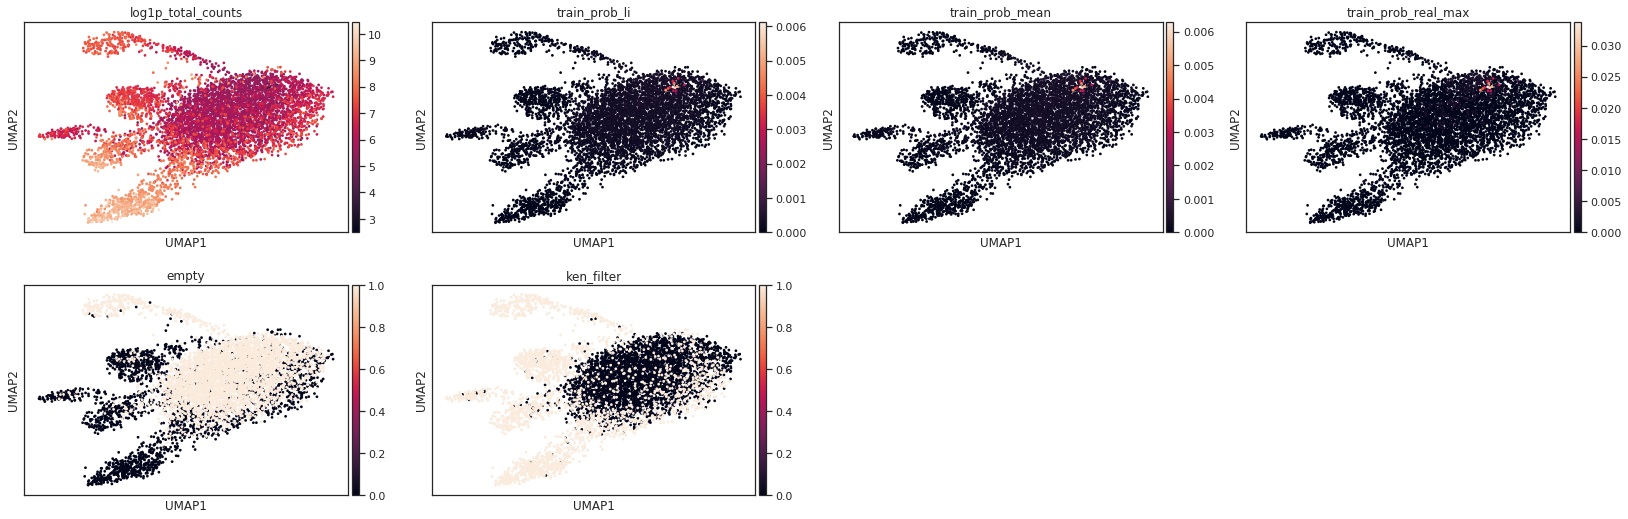

In [747]:
sc.pl.umap(s1, color=['log1p_total_counts', 'train_prob_li', 'train_prob_mean', 'train_prob_real_max', 'empty', 'ken_filter'], size=30)

In [748]:
#ken_filterDR_plot(dim_name='UMAP', figsize=(3.5,3.5)).plot_IDs(s1, use_rep='X_umap', obs_col='train', pt_size=18)
#DR_plot(dim_name='UMAP', figsize=(3.5,3.5)).plot_IDs(s1, use_rep='X_umap', obs_col='ken_filter', pt_size=18)

Compare our training set to Ken's filter.  
We want a small number here, but <= 50 is acceptable, since our machine learning classifier will work out the kinks...

In [749]:
ken_li_set = len(set(s1.obs.loc[s1.obs['ken_filter']==1].index).difference(set(s1.obs.loc[s1.obs['train_li']==0].index)))
ken_mean_set = len(set(s1.obs.loc[s1.obs['ken_filter']==1].index).difference(set(s1.obs.loc[s1.obs['train_mean']==0].index)))
ken_real_max_set = len(set(s1.obs.loc[s1.obs['ken_filter']==1].index).difference(set(s1.obs.loc[s1.obs['train_real_max']==0].index)))
ken_emptyDrops_set = len(set(s1.obs.loc[s1.obs['ken_filter']==1].index).difference(set(s1.obs.loc[s1.obs['empty']==0].index)))

In [750]:
print("ken vs. li: ", ken_li_set)
print("ken vs. mean: ", ken_mean_set)
print("ken vs. real max: ", ken_real_max_set)
print("ken vs. emptyDrops: ", ken_emptyDrops_set)

ken vs. li:  185
ken vs. mean:  137
ken vs. real max:  5
ken vs. emptyDrops:  422


In [751]:
s1.obs

,ken_filter,mean_mito,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,Limited,FDR,empty,barcode,thresh_li,thresh_mean,thresh_real_max,train_li,train_mean,train_real_max
0,1,66.027023,7182,8.879472,33924.0,10.431908,20.988091,28.599222,37.619385,51.173211,...,True,0.0,0,0,0.0,0.0,0.0,0,0,0
1,1,86.945946,6016,8.702344,26851.0,10.198095,28.881606,35.588991,43.417377,55.886187,...,True,0.0,0,1,0.0,0.0,0.0,0,0,0
2,1,43.270271,6099,8.716044,25590.0,10.149996,19.921844,27.018367,36.291520,50.691676,...,True,0.0,0,2,0.0,0.0,0.0,0,0,0
3,1,45.027027,5938,8.689296,24390.0,10.101970,21.775318,28.798688,37.872079,51.779418,...,True,0.0,0,8,0.0,0.0,0.0,0,0,0
4,1,35.324326,5646,8.638880,24030.0,10.087100,21.223471,28.942988,38.193924,53.116937,...,True,0.0,0,3,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5749,0,0.027027,15,2.772589,15.0,2.772589,100.000000,100.000000,100.000000,100.000000,...,nan,NaN,1,4579,1.0,1.0,1.0,1,1,1
5750,0,0.027027,11,2.484907,14.0,2.708050,100.000000,100.000000,100.000000,100.000000,...,nan,NaN,1,5720,1.0,1.0,1.0,1,1,1
5751,0,0.000000,12,2.564949,13.0,2.639057,100.000000,100.000000,100.000000,100.000000,...,nan,NaN,1,5003,1.0,1.0,1.0,1,1,1
5752,0,0.000000,12,2.564949,12.0,2.564949,100.000000,100.000000,100.000000,100.000000,...,nan,NaN,1,4586,1.0,1.0,1.0,1,1,1


In [752]:
s1.obs.loc[:, ["barcode", "train_li", "train_mean", "train_real_max", "total_counts", "log1p_total_counts", "n_counts", "pct_counts_mito"]].to_csv("thresholded-3777-S2.csv", index = False)

/home/victoria/anaconda3/envs/LauLab/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
